In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Training',
    seed = 123,
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

Found 5712 files belonging to 4 classes.


In [10]:
class_names = dataset.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [11]:
len(dataset)

179

In [12]:
# image batch is the 32 batches of images
# label batch returns labels of images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 3 1 1 1 0 0 3 1 3 2 1 3 2 2 1 1 2 1 0 2 2 3 3 2 3 1 3 1 1 0 3]


In [13]:
# 3d color array of the first image of the batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[ 1.  1.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 1.  1.  1.]
  [ 2.  2.  2.]
  [ 2.  2.  2.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 5.  5.  5.]
  [ 5.  5.  5.]
  [ 4.  4.  4.]]

 ...

 [[15. 15. 15.]
  [25. 25. 25.]
  [27. 27. 27.]
  ...
  [11. 11. 11.]
  [ 5.  5.  5.]
  [ 4.  4.  4.]]

 [[18. 18. 18.]
  [21. 21. 21.]
  [20. 20. 20.]
  ...
  [ 7.  7.  7.]
  [ 1.  1.  1.]
  [ 0.  0.  0.]]

 [[ 2.  2.  2.]
  [ 3.  3.  3.]
  [ 4.  4.  4.]
  ...
  [14. 14. 14.]
  [ 9.  9.  9.]
  [ 2.  2.  2.]]]


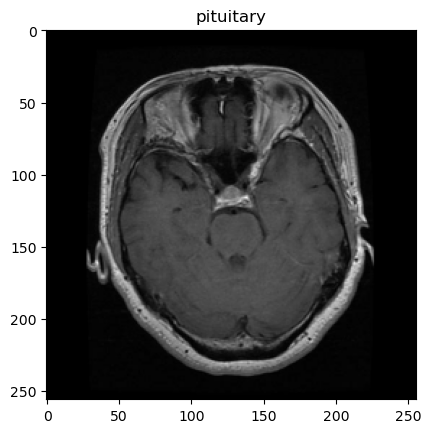

In [14]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

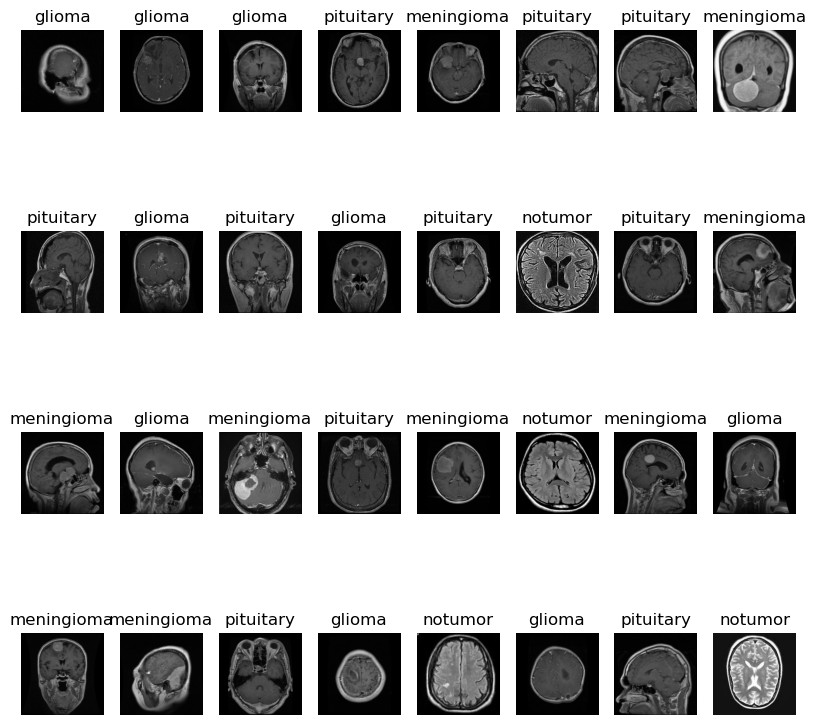

In [15]:
# subplot visualization for first batch 
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4,8, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    
plt.show()
        

In [16]:
## Train dataset
train_size = 0.8
len(dataset) * train_size

143.20000000000002

In [17]:
train_ds = dataset.take(143)
test_ds = dataset.skip(143)

In [18]:
val_size =  0.1
val_size * len(dataset)

17.900000000000002

In [19]:
# validation set
val_ds = test_ds.take(17)
len(val_ds)

17

In [20]:
# test set
test_ds = test_ds.skip(17)
len(test_ds)

19

In [21]:
#shuffle and prefetch data to increase speed of reading and training images 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
# resize and rescaling images
r_r = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/256)])

In [16]:
# data augmentation to generate more data to improve accuracy of model
data_augmentation  = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
# build model

input_shape = (32,256,256,3)
n_classes=4

model = models.Sequential([
    r_r,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = 'softmax'),

])

model.build(input_shape = input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [20]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
143/143 [==============================] - 103s 698ms/step - loss: 1.0405 - accuracy: 0.5341 - val_loss: 0.8671 - val_accuracy: 0.6397
Epoch 2/50
143/143 [==============================] - 106s 744ms/step - loss: 0.6996 - accuracy: 0.7306 - val_loss: 0.7428 - val_accuracy: 0.7224
Epoch 3/50
143/143 [==============================] - 105s 737ms/step - loss: 0.6505 - accuracy: 0.7493 - val_loss: 0.6942 - val_accuracy: 0.7224
Epoch 4/50
143/143 [==============================] - 107s 743ms/step - loss: 0.5810 - accuracy: 0.7782 - val_loss: 0.5930 - val_accuracy: 0.7665
Epoch 5/50
143/143 [==============================] - 103s 718ms/step - loss: 0.5357 - accuracy: 0.7944 - val_loss: 0.4727 - val_accuracy: 0.8346
Epoch 6/50
143/143 [==============================] - 114s 794ms/step - loss: 0.4755 - accuracy: 0.8184 - val_loss: 0.5515 - val_accuracy: 0.7849
Epoch 7/50
143/143 [==============================] - 108s 753ms/step - loss: 0.4361 - accuracy: 0.8317 - val_loss: 0.5039 -

In [21]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 7s 219ms/step - loss: 0.1265 - accuracy: 0.9544


In [37]:
scores

[0.12653537094593048, 0.9543918967247009]

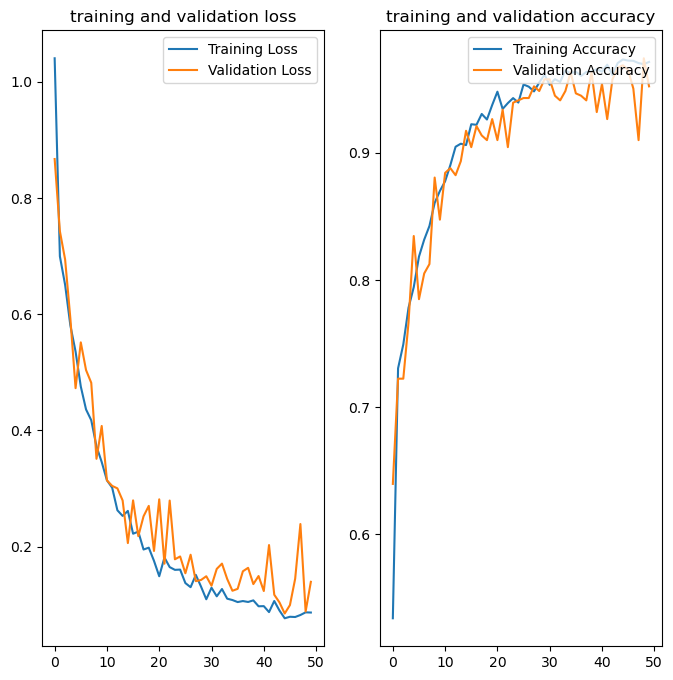

In [40]:
#Visualize loss/accuracy
acc = history.history["accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(50),loss, label = "Training Loss")
plt.plot(range(50),val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("training and validation loss")

plt.subplot(1,2,2)
plt.plot(range(50),acc, label = "Training Accuracy")
plt.plot(range(50),val_acc, label = "Validation Accuracy")
plt.legend(loc = "upper right")
plt.title("training and validation accuracy")
plt.show()



first image to predict:
actual label: glioma
1/1 [==============================] - 0s 224ms/step
predicted label: glioma


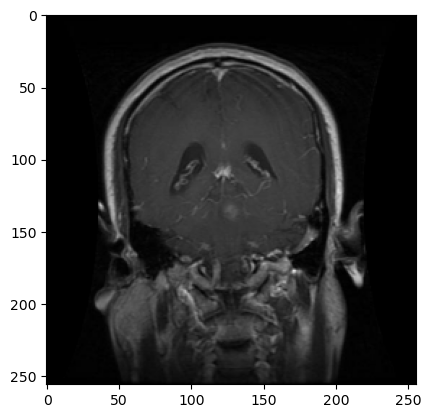

In [51]:
#Predict
import numpy as np
for image_batches, image_labels in test_ds.take(1):
    first_image = image_batches[0].numpy().astype('uint8')
    first_label = image_labels[0].numpy()
    
    print("first image to predict:")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batches)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    

In [ ]:
# save model
model.save("model.h5")

In [22]:
new_model = models.load_model('model.h5')

In [24]:
#def pred function
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
    
    

1/1 [==============================] - 0s 15ms/step


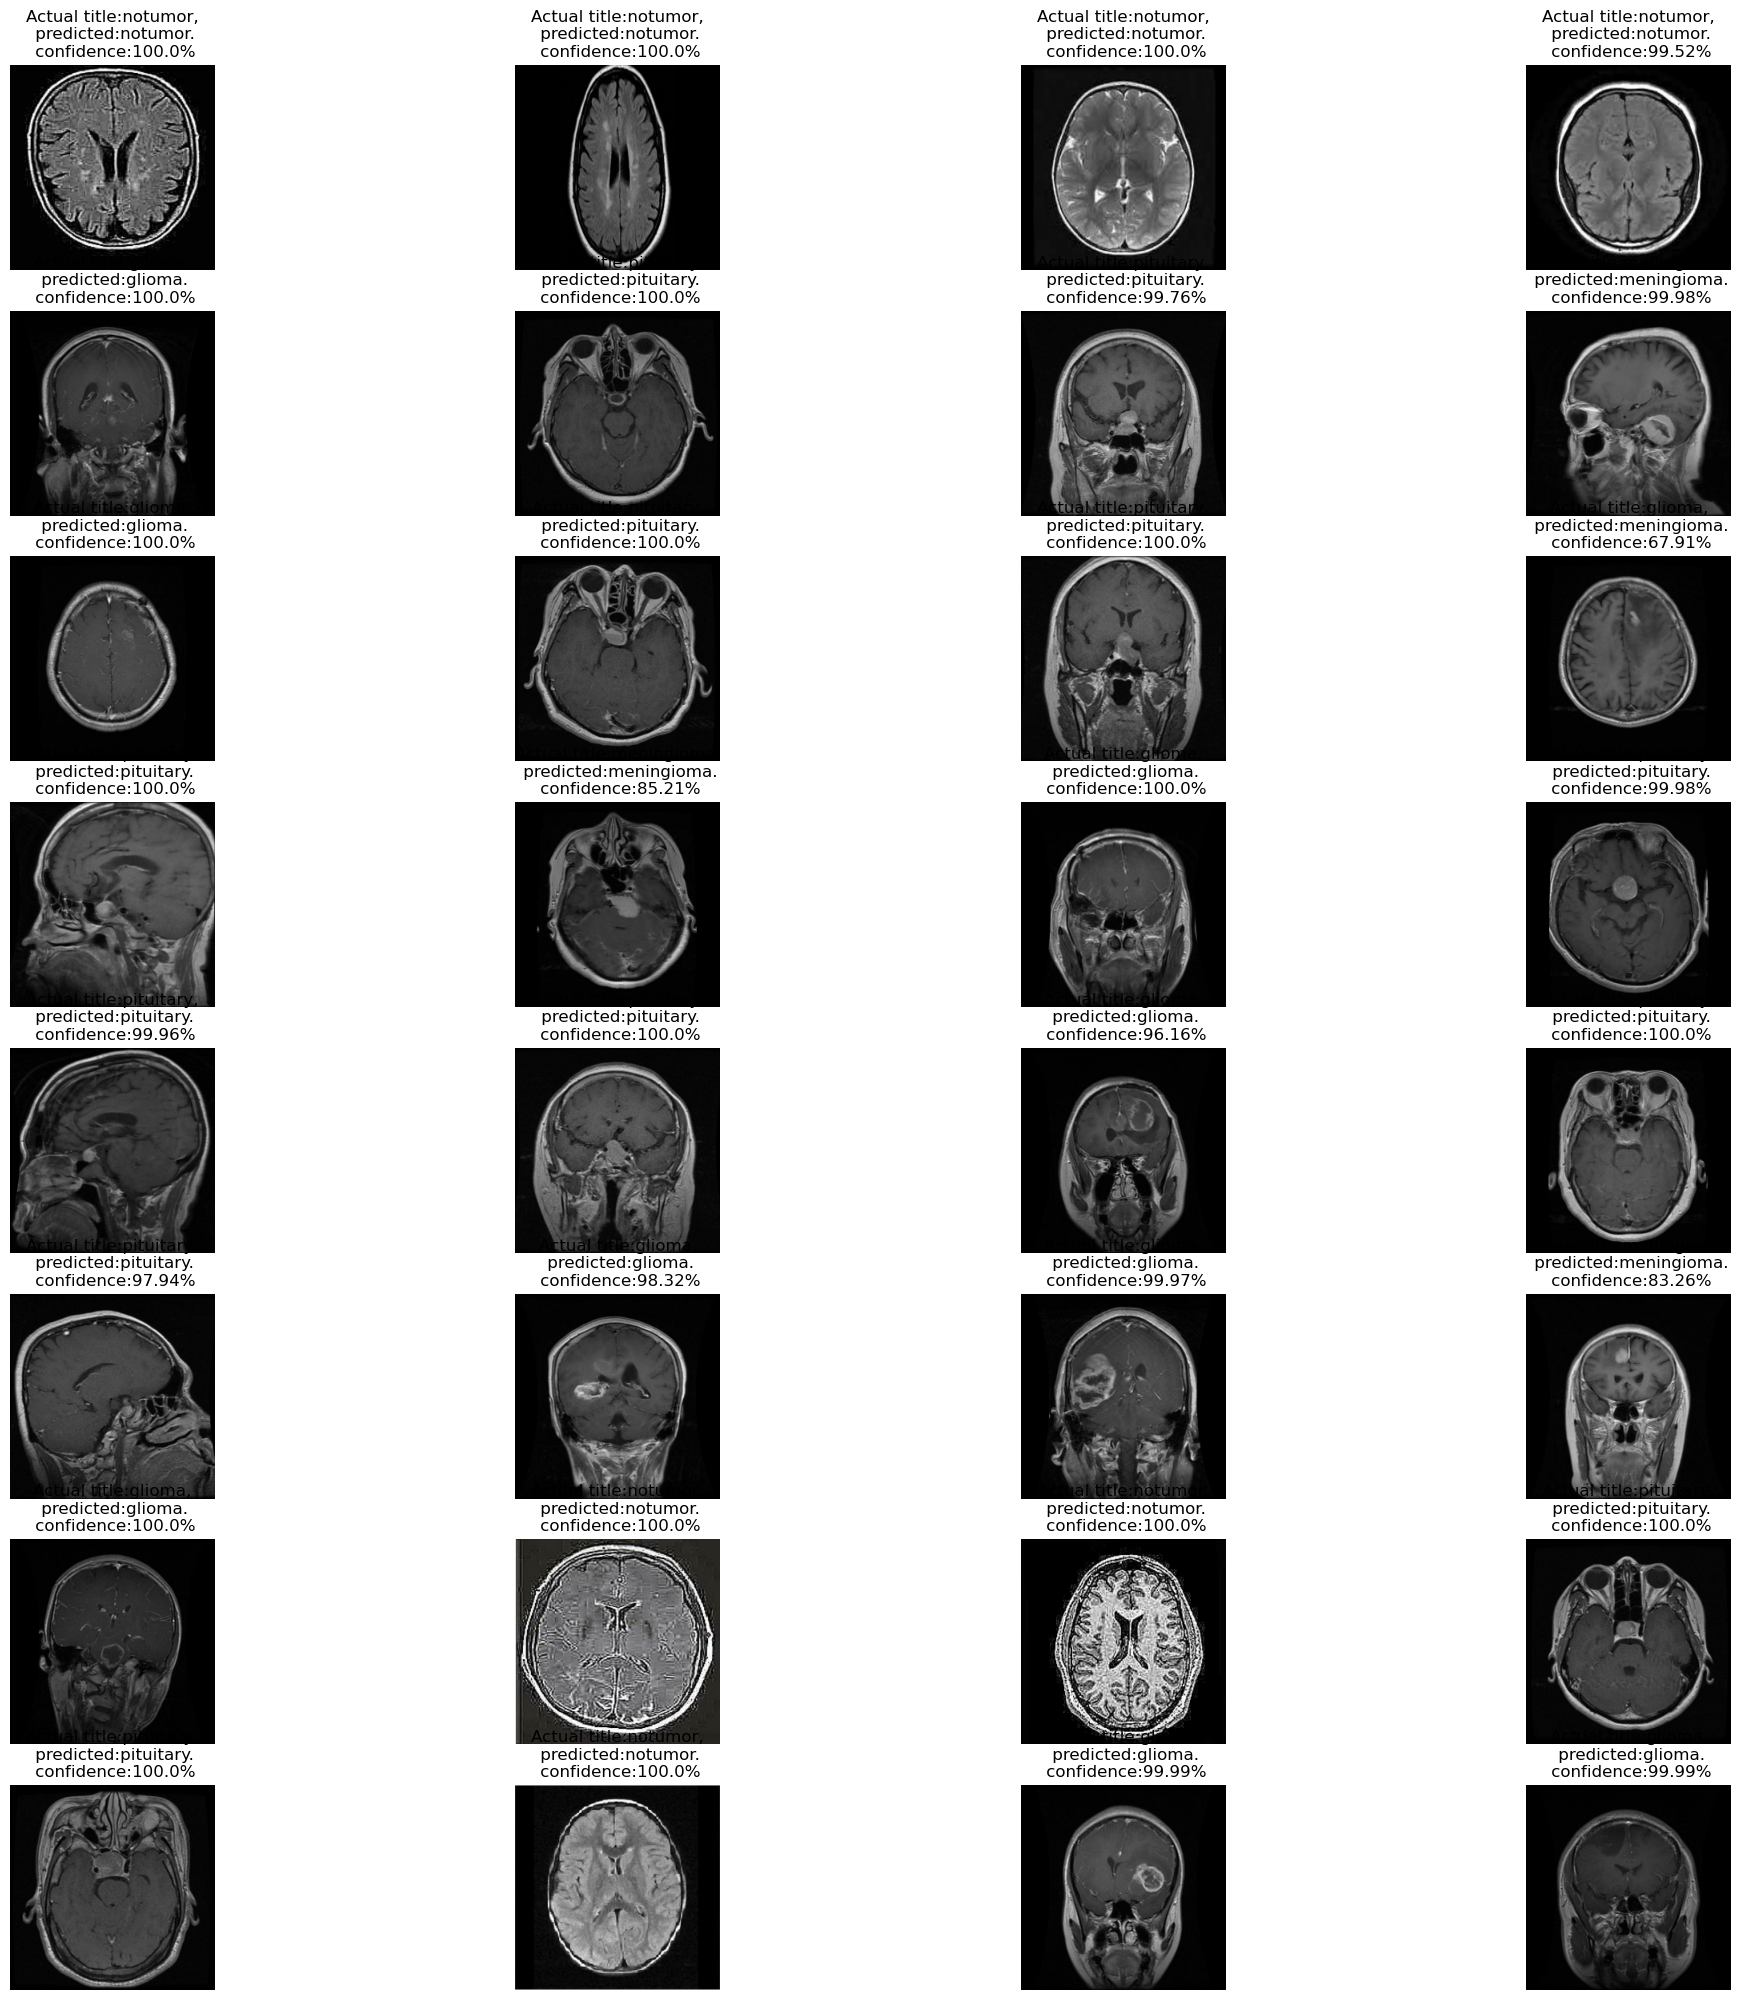

In [30]:
# running inferese on batch images
import numpy as np
plt.figure(figsize=(25, 25))
for images, labels in test_ds.take(1):
    for i in range(32):
        ax = plt.subplot(8,4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = pred(new_model,images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual title:{actual_class},\n predicted:{predicted_class}.\n confidence:{confidence}%")
        plt.axis("off")
    
    